In [160]:
from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import networkx as nx
import community
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [2]:
def compute_C_minus_C0(lambdas,v,lambda_plus):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    v_m=np.matrix(v)
    
    # TO CHECK: WHY N-1?!?!? isn't range enough to stop at N-1?!
    # _s stands for _structure below: 
    for i in range(N-1):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    
    

In [199]:
def LouvainCorrelationClustering(R):   # R is a matrix of return
    
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
      
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    mygraph= nx.from_numpy_matrix(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)
    DF=pd.DataFrame.from_dict(partition,orient="index")
    DF['StockName'] = R.columns
    DF = DF.reset_index()
    DF = DF.drop(columns = 'index')
    DF = DF.rename({0: 'Cluster'},axis = 'columns')
    DF = DF.set_index('StockName')
    
    return(DF)

In [134]:
clust_louvain=LouvainCorrelationClustering(DF_cut)
print(clust_louvain)
# print(clust_louvain.value_counts()) # 6 clusters

    0
0   0
1   1
2   0
3   0
4   2
.. ..
89  4
90  4
91  1
92  1
93  4

[94 rows x 1 columns]
           Cluster
StockName         
^GSPC            0
GE               1
IBM              0
DIS              0
BA               2
...            ...
GRA              4
LPX              4
VLO              1
WMB              1
TXI              4

[94 rows x 1 columns]


In [131]:
import numpy as np

DF=pd.read_parquet("us_equities_logreturns.parquet")

DF_cut = drop_nans(DF)

Index(['^GSPC', 'GE', 'IBM', 'DIS', 'BA', 'CAT', 'AA', 'HPQ', 'DD', 'KO',
       ...
       'NSM', 'CLP', 'CTX', 'CTR', 'DYN', 'AIB', 'KIM', 'SFN', 'TCO', 'S'],
      dtype='object', length=1012)


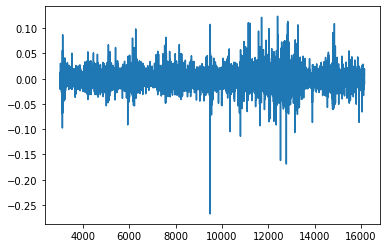

In [6]:
import matplotlib.pyplot as plt
print(DF.columns)
plt.plot(DF['IBM'].index, DF['IBM'])
#The returns are daily because 16k/252 is around 60 years

## Louvain clustering

In [206]:
clust_louvain=LouvainCorrelationClustering(DF_cut)
#print(clust_louvain)
#print(clust_louvain.value_counts()) # 6 clusters

def drop_nans(df,limit = 0.5):
    """given a dataframe and a limit value, first drops all the columns that have
    more than limit % nans than drops all raws containing at least one nan value"""
    row_num = df.shape[0]
    nan_col = df.isnull().sum(axis=0)>(row_num*limit)
    df=df.drop(columns=df.columns[nan_col])
    return df.dropna()

def pick_n_from_k(df,n,seed = 0,onlynames = False):
    """given a dataframe and a number N, returns a dataframe that 
    contains n randomly selected columns of the input dataframe"""
    
    k = df.shape[0]
    
    #safety check
    assert k >= n, 'K should be >= N'
    
    #if onlynames is active return only the name of the columns
    if onlynames:
        random.seed(seed)
        return random.sample(list(df.columns), n)
    return df.sample(n=n, random_state=seed, axis='columns')

def bootstrap_CI(data, nbr_draws):
    """Given an array and a number of random samples performs bootstrapping to
    find the confidence intervals of the mean"""
    # Input: your array and the number of random samples (e.g., 1000 is a good number)
    # Output: [lower error, upper error]

    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 0.5),np.nanpercentile(means, 99.5)]

def optimalWeights(df,verbose = False,shortBan = True):
    """use pypfopt to compute the optimal weights of the portfolio following markovitz strategy"""
    mu = expected_returns.mean_historical_return(df,returns_data=True,log_returns =True)
    S = risk_models.sample_cov(df,returns_data=True,log_returns =True)
    if shortBan:
        #By default the ef is long only 
        ef = EfficientFrontier(mu, S)
    else:
        #Allow negative weights => No shortBan
        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    #We could limit the maxweight just by changing the bounds ex: max 10% with shortban weight_bounds=(0, 0.1)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    if verbose:
        return ef.portfolio_performance(verbose=False)
    return cleaned_weights

def weight_inverse_std(df):
    """Helper function for the inner-cluster aggregation using inverse std technique.
    Given a df containing all data of a cluster rescale the value of returns of each stock
    taking as weight the sum(std)/std then aggregate all the returns toghether. 
    The following methods will use this portfolio of clustered stocks as a single 
    stock and compose a portfolio"""
    sum_stds = 0
    cluster = df['Cluster'].iloc[0]
    df = df.drop(columns = ['Cluster']).transpose()
    for col in df.columns:
        if col != 'Cluster':
            sum_stds += df[col].std()
    for col in df.columns:
        if col != 'Cluster':
            df[col] = df[col]*sum_stds/df[col].std()
    df = df.sum(axis = 1)
    df = df.transpose()
    df['Cluster'] = cluster
    #df = df.transpose()
    return df

def compute_clusters_returns(df,clusters,intra_cluster_strategy = 'equal weight'):
    """given a dataframe and his clusters compute the clusters means"""
    
    if intra_cluster_strategy == 'equal weight':
        means = df.transpose()
        means = pd.merge(means, clusters,left_index = True, right_on='StockName')
        means = means.groupby('Cluster').mean().transpose()
    elif intra_cluster_strategy == 'inverse std':
        #TO DO: test this method
        dftr = df.transpose()
        dftr = pd.merge(dftr, clusters,left_index = True, right_on='StockName')
        means = dftr.groupby('Cluster').apply(lambda x: weight_inverse_std(x))
        means = means.drop(columns = ['Cluster']).transpose()
    return means

def compute_portfolio_return(df,clustering = 'louvian',inter_cluster_strategy ='equal weight',intra_cluster_strategy = 'equal weight'):
    """given a dataframe, a clustering method and a portfolio weighting strategy
    compute the return of the portfolio composed by appling clustering than combining
    the clusters using the strategy"""
    if inter_cluster_strategy == 'equal weight':
        
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
            
        cluster_means = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        portfolio_mean = cluster_means.mean().mean()
        portfolio_std = cluster_means.mean(axis = 1).std()
        portfolio_std = np.exp((portfolio_std)*252)-1
        portfolio_mean = np.exp((portfolio_mean)*252)-1
        SharpR = portfolio_mean/portfolio_std
        return portfolio_mean,portfolio_std,SharpR
        
    elif inter_cluster_strategy == 'inverse std':
        
        if clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
               
        cluster_means = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        cluster_std = cluster_means.std()
        weights = np.array([ i/sum(list(cluster_std)) for i in list(cluster_std)]).T
        # I dont know if I can do the mean before or not maybe it changes if variables are dependent
        portfolio_mean = (np.array(cluster_means)@weights).mean()
        portfolio_std = (np.array(cluster_means)@weights).std()
        portfolio_std = np.exp((portfolio_std)*252)-1
        portfolio_mean = np.exp((portfolio_mean)*252)-1
        SharpR = portfolio_mean/portfolio_std
        return portfolio_mean,portfolio_std,SharpR
        
    elif inter_cluster_strategy == 'markovitz':
        if clustering == 'NO clustering':
            #no clustering only markovitz portfolio
            portfolio_mean, portfolio_std, SharpR = optimalWeights(df,verbose = True)
            return portfolio_mean,portfolio_std,SharpR
        
        elif clustering == 'louvian':
            clusters = LouvainCorrelationClustering(df)
            
        elif clustering == 'GiadaMarsili':
            clusters = aggregateClusters_(df)
    
        cluster_means = compute_clusters_returns(df,clusters,intra_cluster_strategy)
        portfolio_mean, portfolio_std, SharpR = optimalWeights(df,verbose = True)
        return portfolio_mean,portfolio_std,SharpR
             
def compute_stategy_avg_return(df,n,n_picks,clustering = 'louvian',inter_cluster_strategy ='equal weight',intra_cluster_strategy = 'equal weight'):
    """given a dataframe, a number of picks, a size n, a clustering method and a portfolio weighting strategy
    compute the average return of n_picks portfolios composed picking at random n stocks from the df,
    applying clustering and combining with the weight strategy"""
    portfolio_returns = []
    portfolio_risks = []
    portfolio_sharpRs = []
    for i in range(n_picks):
        sub_df = pick_n_from_k(df,n,seed = (i+1))
#         print(list(sub_df.columns))
        portfolio_return,portfolio_risk,SharpR = compute_portfolio_return(sub_df,clustering = clustering,inter_cluster_strategy =inter_cluster_strategy,intra_cluster_strategy = intra_cluster_strategy)
        print('portfolio nb: ',i, 'return: ',portfolio_return)
        portfolio_returns.append(portfolio_return)
        portfolio_risks.append(portfolio_risk)
        portfolio_sharpRs.append(SharpR)
    portfolio_returns_mean = sum(portfolio_returns)/len(portfolio_returns)
    CI = bootstrap_CI(portfolio_returns,int(n_picks/1.5))
    yerr = [-(CI[0]-portfolio_returns_mean),CI[1]-portfolio_returns_mean]
#     print(portfolio_returns_mean)
    plt.errorbar(1,portfolio_returns_mean,yerr = np.array(yerr).reshape(2,1), fmt='.', ecolor = 'red')
    plt.ylabel("Mean return of clustering method :" + clustering +' intra ' + intra_cluster_strategy +' inter ' + inter_cluster_strategy)
    plt.title("Mean return of clustering method with confidence intervals")
    return portfolio_returns,portfolio_risks,portfolio_sharpRs

In [207]:
DF=pd.read_parquet("us_equities_logreturns.parquet")

DF = drop_nans(DF)
#display(DF)

In [212]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,clustering = 'GiadaMarsili'))

ValueError: Length of values (65) does not match length of index (218)

In [ ]:
print('strategy inv std: ',compute_stategy_avg_return(DF,65,10,inter_cluster_strategy ='equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight'))

In [ ]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,inter_cluster_strategy ='equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight'))

In [ ]:
print('strategy mean: ',compute_stategy_avg_return(DF,65,10,inter_cluster_strategy ='equal weight',clustering = 'louvian',intra_cluster_strategy = 'equal weight'))

## Maximum likelihood clustering



There is no code for this method in Python. The following shows how to call R from Python.

In [ ]:
#!pip install rpy2 -U
# first install R https://cran.rstudio.com/
# # run this cell the first time you use rpy2 only.

# from rpy2.robjects.packages import importr
# utils = importr('utils')
# utils.install_packages("data.table")
 

In [ ]:
DF=pd.read_parquet("us_equities_logreturns.parquet")

DF_cut=DF.iloc[-5000:]

sel=DF_cut.isnull().sum(axis=0)>0
DF_cut=DF_cut.drop(columns=DF_cut.columns[sel])


In [192]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

r = robjects.r
rpy2.robjects.numpy2ri.activate()

#importr("data.table")

newfunc = r.source("libClusteringGiadaMarsiliFast.R")
aggregateClusters=robjects.globalenv["aggregateClusters"]

In [215]:
def aggregateClusters_(R,aggregateClusters=aggregateClusters):
    """Slight modification to the original function taken from "libClusteringGiadaMarsiliFast.R" package.
    The modification is made in order to simplify the use and to produce the output with the same format as
    the previous clustering method"""
    C = R.corr()
    intermediate_result = aggregateClusters(C.values)
    nb_clusters = len(intermediate_result[3])
    ls_dfs = []
    for i in range(nb_clusters):
        df = pd.DataFrame(np.array(intermediate_result[3][i]),columns = ['Stock Name'])
        df['Cluster'] = i
        ls_dfs.append(df)
    df = pd.concat(ls_dfs)
    df['StockName'] = R.columns
    df = df.reset_index()
    df = df.drop(columns = 'index')
    df = df.drop(columns = 'Stock Name')
    df = df.rename({0: 'Cluster'},axis = 'columns')
    df = df.set_index('StockName')

    return df

In [ ]:
display(aggregateClusters_(DF_cut))
print('-------------------------------------------------------------------')
display(LouvainCorrelationClustering(DF_cut))